<a href="https://colab.research.google.com/github/sohil344/EDA/blob/main/DS_Salary_Full_EDA_%7C_%F0%9F%8C%8EGeo_%7C_%F0%9F%92%B9Prediction_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Domain Knowledge
1. **`work_year` [categorical] :** The year the salary was paid.

2. **`experience_level` [categorical] :** The experience level in the job during the year.

3. **`employment_type` [categorical] :** The type of employment for the role.

4. **`job_title` [categorical] :** The role worked in during the year.

5. **`salary` [numerical] :** The total gross salary amount paid.

6. **`salary_currency` [categorical] :** The currency of the salary paid as an ISO 4217 currency code.

7. **`salaryinusd` [numerical] :** The salary in USD.

8. **`employee_residence` [categorical]:** Employee s primary country of residence in during the work year as an ISO 3166 country code.

9. **`remote_ratio` [ratio]:** The overall amount of work done remotely.

10. **`company_location` [categorical]:** The country of the employer's main office or contracting branch.

11. **`company_size` [categorical]:** The median number of people that worked for the company during the year as an ISO 3166 country code.


In [3]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from scipy import stats
from scipy.stats import norm

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
from sklearn.pipeline import Pipeline

!pip install pycountry -q
import pycountry

In [4]:
data = pd.read_csv('/content/ds_salaries (1).csv')


### Exploratory Data Analysis


In this study, we aim to provide an insightful analysis of data science job salaries using a dataset containing information on adjusted salaries, employee residence, company location, and other relevant details. The goal is to explore trends and patterns that can help job seekers and employers make informed decisions.

**1. Check Null and Missing Values**

In [5]:
data.isnull().sum()

work_year             0
experience_level      0
employment_type       0
job_title             0
salary                0
salary_currency       0
salary_in_usd         0
employee_residence    0
remote_ratio          0
company_location      0
company_size          0
dtype: int64

There is no any Null Values

**Check Duplicates**

In [6]:
duplicate_rows=data[data.duplicated()]
print("Number of Duplicated Rows",duplicate_rows.shape)

Number of Duplicated Rows (1171, 11)


**Check Unique values in each column**

In [7]:
for column in data.columns:
  num_distinct_values=len(data[column].unique())
  print(f"{column}: {num_distinct_values} ")

work_year: 4 
experience_level: 4 
employment_type: 4 
job_title: 93 
salary: 815 
salary_currency: 20 
salary_in_usd: 1035 
employee_residence: 78 
remote_ratio: 3 
company_location: 72 
company_size: 3 


**Explore Data**

In [8]:
data.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M


In [9]:
data['experience_level'].value_counts()

SE    2516
MI     805
EN     320
EX     114
Name: experience_level, dtype: int64

In [10]:
data['experience_level']=data['experience_level'].replace(
    {'SE':'Senior Level',
     'MI':"Mid Level",
     'EN':"Entry Level",
     'EX':"Executive Level"}
)

In [11]:
data['employment_type'].value_counts()

FT    3718
PT      17
CT      10
FL      10
Name: employment_type, dtype: int64

In [12]:
data['employment_type']=data['employment_type'].replace({
    'FT':'Full Time',
    'PT':"Part Time",
    'CT':'Contract Type',
    'FL':'Free Lancer'
}
)

In [13]:
data['remote_ratio'].value_counts()

0      1923
100    1643
50      189
Name: remote_ratio, dtype: int64

In [14]:
data['remote_ratio']=data['remote_ratio'].replace({
    '0':'On-Site',
    '100':'Full-remote',
    '50':'Hybrid'
})

**Group the job title**

In [15]:
def assign_broader_category(job_title):
    data_engineering = ["Data Engineer", "Data Analyst", "Analytics Engineer", "BI Data Analyst", "Business Data Analyst", "BI Developer", "BI Analyst", "Business Intelligence Engineer", "BI Data Engineer", "Power BI Developer"]
    data_scientist = ["Data Scientist", "Applied Scientist", "Research Scientist", "3D Computer Vision Researcher", "Deep Learning Researcher", "AI/Computer Vision Engineer"]
    machine_learning = ["Machine Learning Engineer", "ML Engineer", "Lead Machine Learning Engineer", "Principal Machine Learning Engineer"]
    data_architecture = ["Data Architect", "Big Data Architect", "Cloud Data Architect", "Principal Data Architect"]
    management = ["Data Science Manager", "Director of Data Science", "Head of Data Science", "Data Scientist Lead", "Head of Machine Learning", "Manager Data Management", "Data Analytics Manager"]
    
    if job_title in data_engineering:
        return "Data Engineering"
    elif job_title in data_scientist:
        return "Data Science"
    elif job_title in machine_learning:
        return "Machine Learning"
    elif job_title in data_architecture:
        return "Data Architecture"
    elif job_title in management:
        return "Management"
    else:
        return "Other"

# Apply the function to the 'job_title' column and create a new column 'job_category'
data['job_category'] = data['job_title'].apply(assign_broader_category)

## <div style="padding: 20px;color:white;margin:10;font-size:90%;text-align:left;display:fill;border-radius:10px;overflow:hidden;background-image: url(https://w0.peakpx.com/wallpaper/957/661/HD-wallpaper-white-marble-white-stone-texture-marble-stone-background-white-stone.jpg)"><b><span style='color:black'> 2. Dealing with Inflation rate</span></b> </div>


### <b> <span style='color:#85BB65'>|</span> Adjusted the income to Present Value</b> 
<br>


![](https://www.halifax.co.uk/assets/financial-planning-centre/inflation-projection.png)


<br>

In order to accurately compare salaries across different years, it is essential to account for inflation. Inflation is the rate at which the general price levels of goods and services increase over time. By adjusting salaries to a common currency and year, we can make meaningful comparisons between them.

<br>

![](https://timeseriesreasoning.files.wordpress.com/2021/05/88f72-1gjxkmcxhudin7t07swj0mq.png)



<br>

To adjust salaries from different years to their present value for comparison purposes. We will be using a dataset containing information on employee salaries, work years, and currency.

<br>

### <b><span style='color:#85BB65'>|</span> Explanation:</b>

<br>

1. **Define inflation rates** for the United States (US) and global markets. These rates will be used to adjust the salaries based on the year and currency.

2. Create a function **adjust_salary()** that takes a row from the dataset as input and calculates the adjusted salary based on the work year, original salary, and currency. If the work year is 2023, the salary does not need to be adjusted, and the original salary is returned.

3. Determine the **number of years between the work year and 2023** . Use the appropriate inflation rate based on the currency, either the US or global inflation rate.

4. Calculate the adjusted salary by **applying the inflation rate** to the original salary for each year from the work year to 2023.

5. **Apply the adjust_salary() function** to the dataset using the apply() method, and create a new column 'adjusted_salary' with the adjusted salary values.
<br>

> By accounting for inflation, we can gain a better understanding of the true value of salaries in different years and currencies.

In [16]:
#Inflation rates

us_inflation_rates={2019:0.0181,2020:0.0123,2021:0.0470,2022:0.065}
global_inflation_rates={2019:0.0219,2020:0.0192,2021:0.0350,2022:0.088}

#function to adjust salaray

def adjust_salary(row):
  year=row['work_year']
  original_salary=row['salary_in_usd']
  currency=row['salary_currency']

  if year==2023:
    return original_salary
  
  adjusted_salary=original_salary

  for y in range(year,2023):
    if currency=='USD':
      inflation_rate=us_inflation_rates[y]
    else:
      inflation_rate=global_inflation_rates[y]
    
    adjusted_salary *= (1+inflation_rate)
  
  return adjusted_salary


data['Adjusted_salary']=data.apply(adjust_salary,axis=1)



In [17]:
data.head(2)

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,job_category,Adjusted_salary
0,2023,Senior Level,Full Time,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L,Other,85847.0
1,2023,Mid Level,Contract Type,ML Engineer,30000,USD,30000,US,100,US,S,Machine Learning,30000.0


In [18]:
value_counts=data['job_title'].value_counts(normalize=True)
print(len(value_counts))
top_n=min(17,len(value_counts))
top_n


93


17

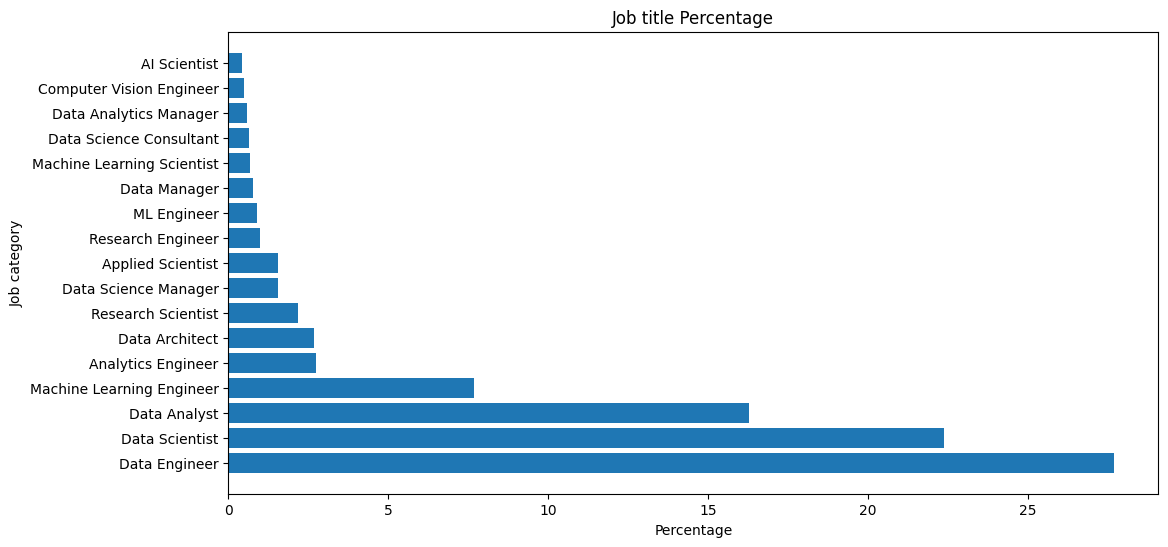

In [19]:
#we will be analyizing top 17 job titles

fig,ax=plt.subplots(figsize=(12,6))
ax.barh(value_counts.index[:top_n],value_counts.values[:top_n]*100)
ax.set_xlabel('Percentage')
ax.set_ylabel("Job category")
ax.set_title("Job title Percentage")
plt.show()

**Distribution across different employee types**

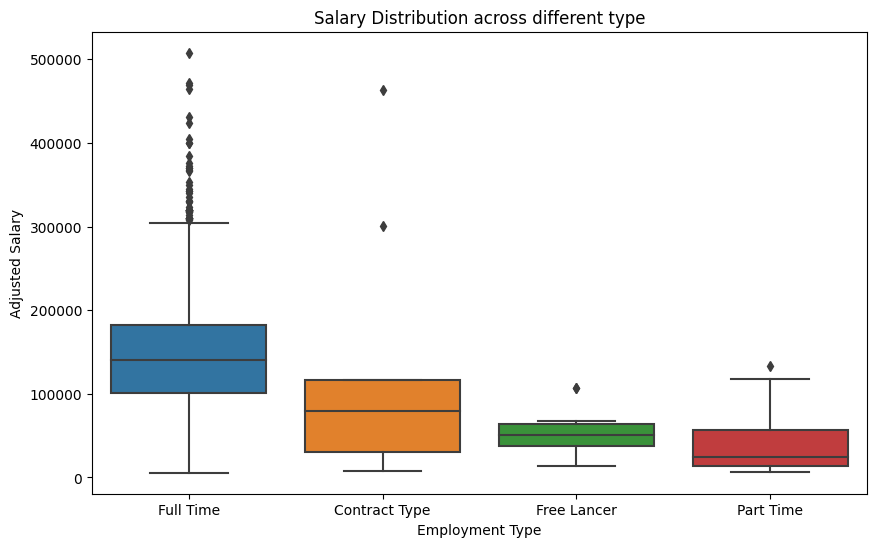

In [20]:
plt.figure(figsize=(10,6))
sns.boxplot(data=data,x='employment_type',y='Adjusted_salary')
plt.title("Salary Distribution across different type")
plt.xlabel('Employment Type')
plt.ylabel("Adjusted Salary")
plt.show()

**Distribution of columns**

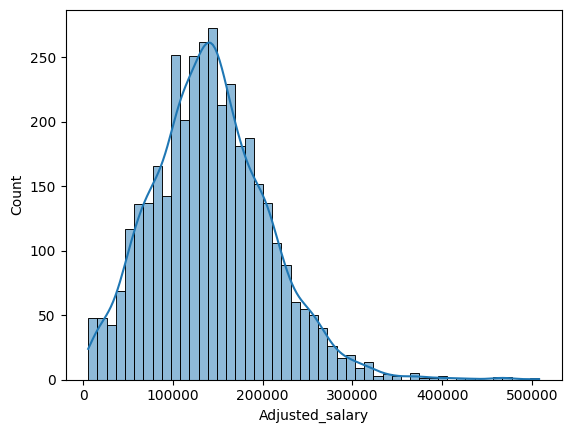

Adjusted_salary: mu =142445.66, sigma=64692.98


In [21]:
#create a list of columns to analyze
columns=['Adjusted_salary']

for col in columns:
  sns.histplot(data[col],kde=True)
  plt.show()

#Fit Normal Distribution to data

(mu,sigma)=stats.norm.fit(data[col])
print('{}: mu ={:.2f}, sigma={:.2f}'.format(col,mu,sigma))


In [22]:
data.columns

Index(['work_year', 'experience_level', 'employment_type', 'job_title',
       'salary', 'salary_currency', 'salary_in_usd', 'employee_residence',
       'remote_ratio', 'company_location', 'company_size', 'job_category',
       'Adjusted_salary'],
      dtype='object')

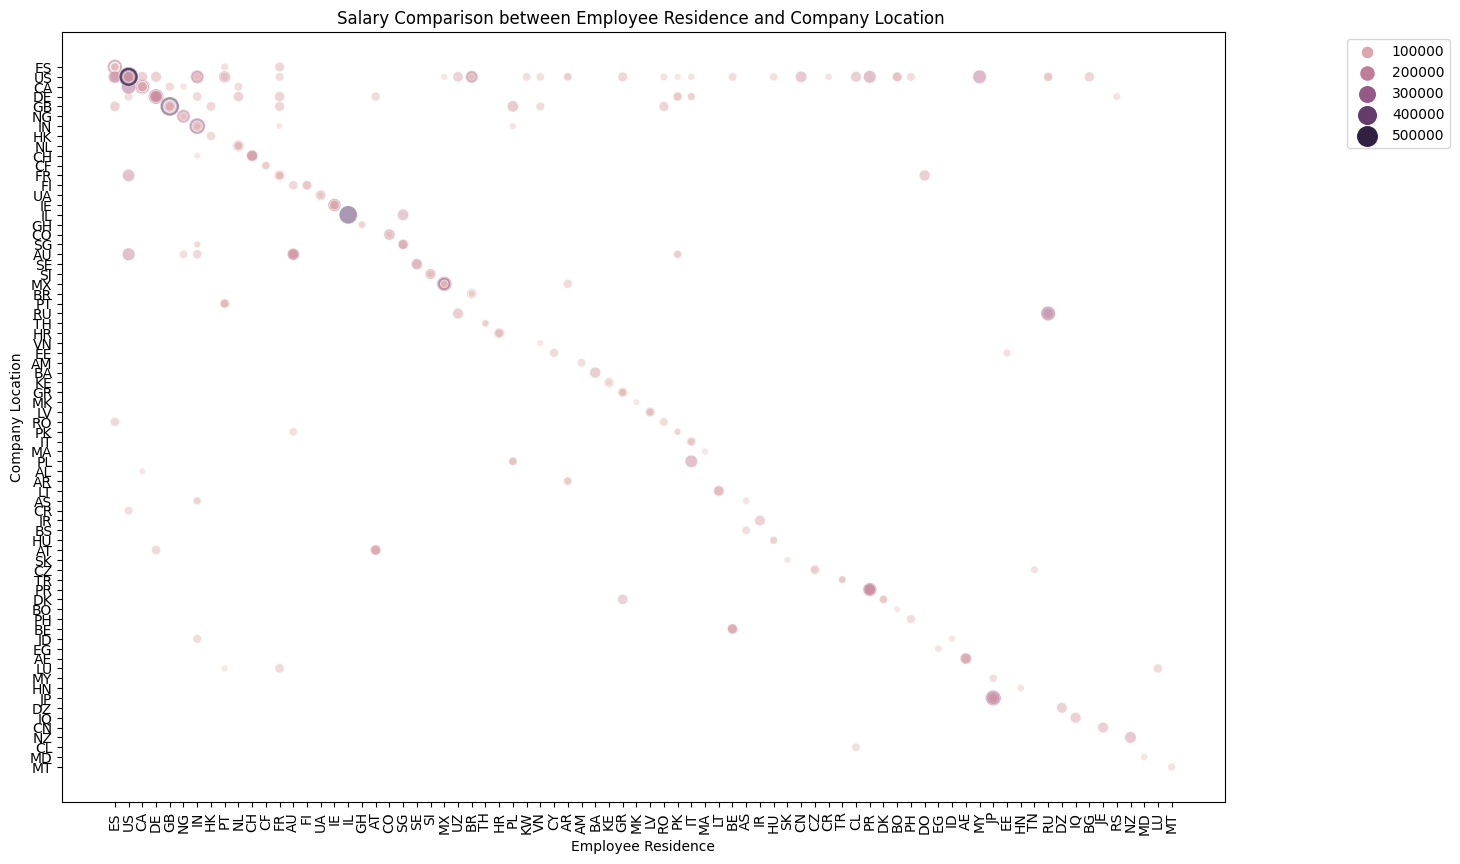

In [27]:
#salary comparison between employee residence and company location

plt.figure(figsize=(15,10))
sns.scatterplot(data=data,x='employee_residence',y='company_location',hue='Adjusted_salary',size='Adjusted_salary',sizes=(20,200),alpha=0.5)
plt.title("Salary Comparison between Employee Residence and Company Location ")
plt.xlabel("Employee Residence")
plt.ylabel("Company Location")
plt.xticks(rotation=90)
plt.legend(loc='best',bbox_to_anchor=(1.2,1))
plt.show()

**Convert Country code to country name**




In [54]:
def country_code_to_name(country_code):
  try:
    return pycountry.countries.get(alpha_2=country_code).name
  except: 
    return country_code
  
def country_code_to_name(code):
  try:
    country=pycountry.countries.get(alpha_2=code)
    return country.name
  except:
    return code

In [30]:
#convert country code to names
data['company_location']=data['company_location'].apply(country_code_to_name)
data['employee_residence']=data['employee_residence'].apply(country_code_to_name)

In [33]:
#Average Salary by Company location

average_salary_company_loc=data.groupby('company_location',as_index=False)['Adjusted_salary'].mean()
average_salary_company_loc


,company_location,Adjusted_salary
0,Albania,10650.000000
1,Algeria,106500.000000
2,American Samoa,31960.074080
3,Argentina,26625.000000
4,Armenia,50000.000000
...,...,...
67,Ukraine,58235.434250
68,United Arab Emirates,108944.523433
69,United Kingdom,91842.061057
70,United States,156743.750170


In [36]:
fig1=px.choropleth(average_salary_company_loc,locations='company_location',locationmode='country names',color='Adjusted_salary',hover_name='company_location',
                   color_continuous_scale=px.colors.sequential.Plasma,
                   title='Average Salary by company location',
                   labels={'Adjusted_salary':'Average Adjusted Salary'},
                   projection='natural earth')
fig1.show()

In [39]:
#Average Salary Company Location
avg_salary_by_location=data.groupby('company_location')['Adjusted_salary'].mean().sort_values(ascending=False)

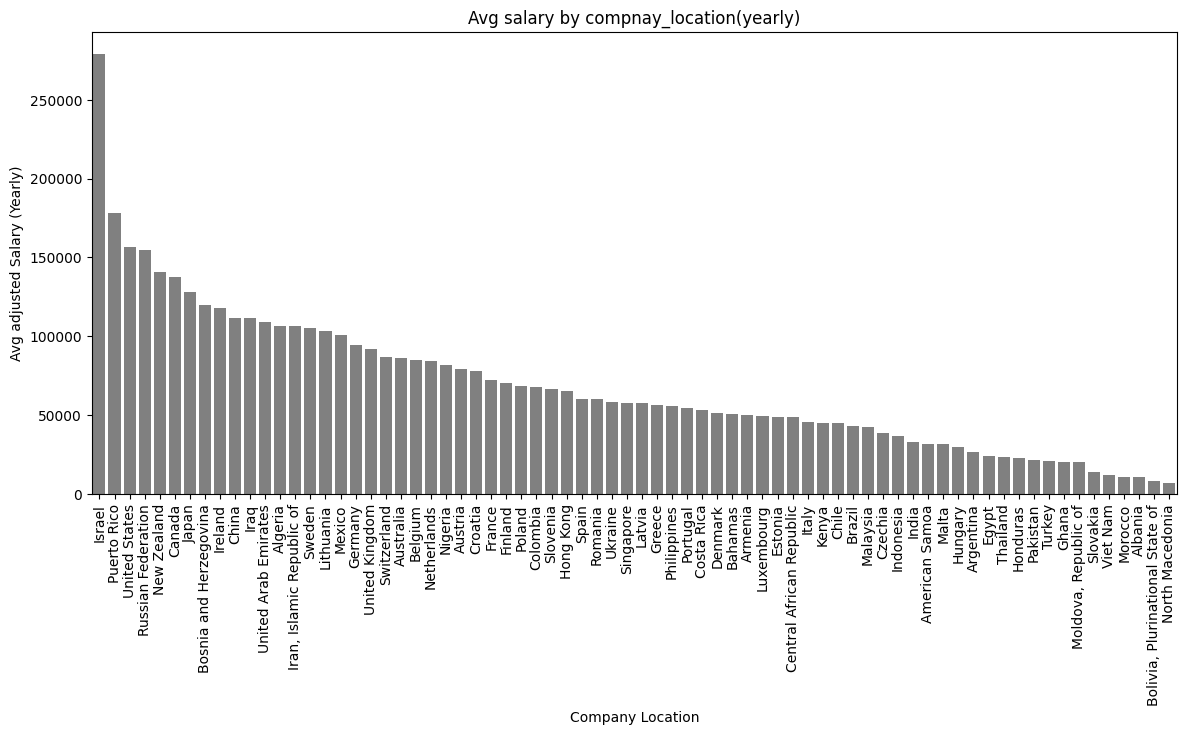

In [40]:
plt.figure(figsize=(14,6))
sns.barplot(x=avg_salary_by_location.index,y=avg_salary_by_location,color='grey')
plt.title('Avg salary by compnay_location(yearly)')
plt.xlabel('Company Location')
plt.ylabel('Avg adjusted Salary (Yearly)')
plt.xticks(rotation=90)
plt.show()

In [42]:
data.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,job_category,Adjusted_salary
0,2023,Senior Level,Full Time,Principal Data Scientist,80000,EUR,85847,Spain,100,Spain,L,Other,85847.0
1,2023,Mid Level,Contract Type,ML Engineer,30000,USD,30000,United States,100,United States,S,Machine Learning,30000.0
2,2023,Mid Level,Contract Type,ML Engineer,25500,USD,25500,United States,100,United States,S,Machine Learning,25500.0
3,2023,Senior Level,Full Time,Data Scientist,175000,USD,175000,Canada,100,Canada,M,Data Science,175000.0
4,2023,Senior Level,Full Time,Data Scientist,120000,USD,120000,Canada,100,Canada,M,Data Science,120000.0


**Which country doesn't demand that you work on the job**

In [64]:
#create dataframe with 100% remote 
# Filter for remote_ratio of 100
remote_100 = data[data['remote_ratio'] == 'Full-Remote']

# Aggregate by country code
country_counts = remote_100['company_location'].value_counts().reset_index()
country_counts.columns = ['country_code', 'count']

# Convert country codes to full names
country_counts['country_name'] = country_counts['country_code'].apply(country_code_to_name)


Series([], Name: country_name, dtype: bool)

In [66]:
## Create the choropleth map with a logarithmic color scale

fig=px.choropleth(country_counts,
                  locations='country_name',
                  locationmode='country names',
                  color=np.log10(country_counts['count']),
                  hover_name='country_name',
                  hover_data=['count'],
                  color_continuous_scale=px.colors.sequential.Plasma,
                  title='Choropleth Map of Full-Remote Compnay location',
                  projection='natural earth')

fig.update_coloraxes(colorbar=dict(title='Count (Log Scale)',tickvals=[0,1,2,3],ticktext=['1','10','100','1000']))
fig.show()

### <b><span style='color:#85BB65'>|</span> Summary of Findings</b>

<br>

* The distribution of adjusted salaries reveals that **most data science professionals earn between 100,000 and 180500 USD per anunum**. However, there are a few high earners that make significantly more than the average.

* The average salary by company location shows that data scientists working for companies based in countries such as **Israel, USA, and Russia tend to have higher average salaries**. On the other hand, companies located in region like **South East Asia, Africa, and Eastern Europe pay comparatively lower average salaries** to data science professionals.

* The analysis of average salary by employee residence indicates that data scientists residing in countries like **Israel, USA, and Malaysia generally earn higher average salaries**. Conversely, data scientists living in countries like Slovakia, Morocco, and North Macedonia have lower average salaries.

* The salary comparison between employee residence and company location reveals that while some data scientists earn high salaries by working for companies based in countries with high-paying job markets, others may need to relocate or work remotely to benefit from these opportunities.

<br>

> In conclusion, this analysis of data science job salaries highlights the impact of various factors, such as company location and employee residence, on salary trends. By understanding these patterns, job seekers and employers can make informed decisions about job opportunities, compensation packages, and talent acquisition strategies.